In [1]:
import son_main_script as soon

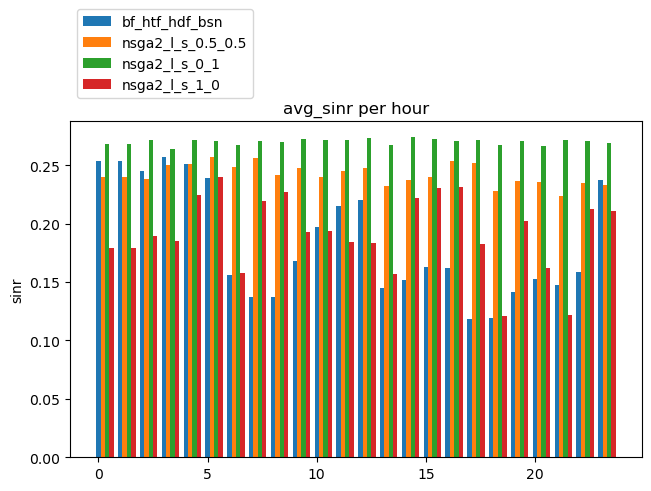

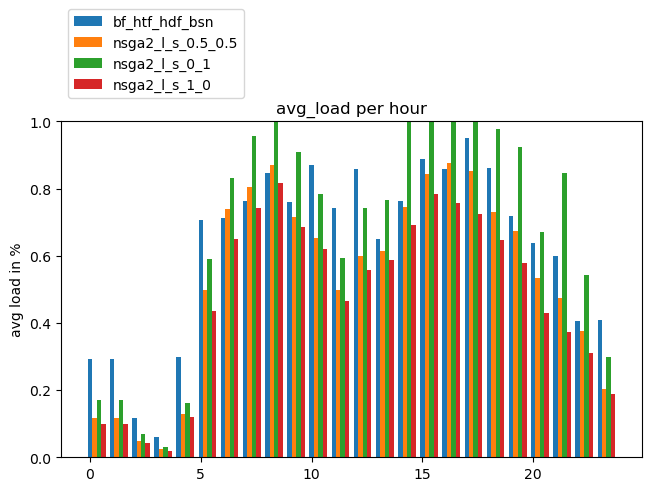

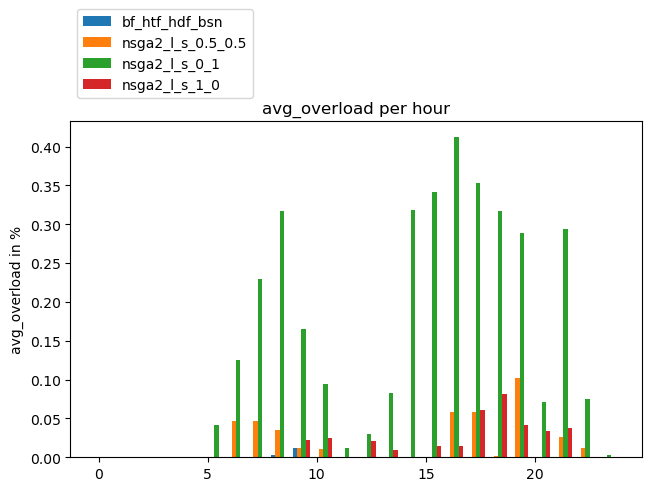

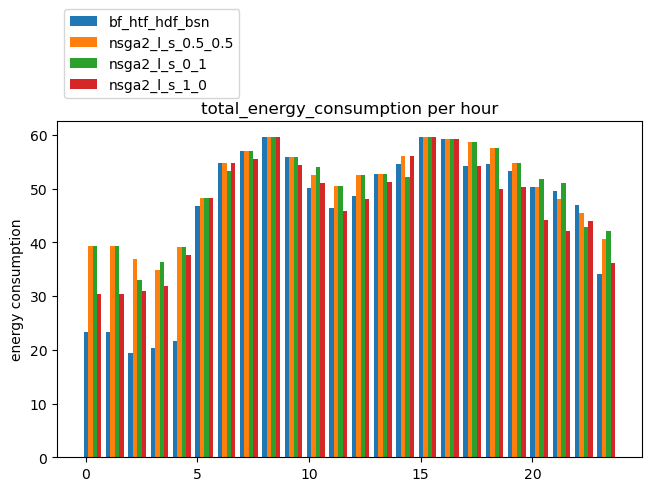

In [2]:
soon.main()

In [3]:
soon.animate_result()